In [1]:
import numpy as np
import imageio
import cv2
import sys
import matplotlib.pyplot as plt

# ORB works poorly with lots of dark pixels,
# probably on account of uint8 quantization to zero.
# This is a very simple brightener - you don't want to 
# use this for the final result
def brighten(img,threshold=0.1): 
    if img.mean() > threshold:
        return img
    else:
        return brighten(2*img - img**2,threshold) # Closes over [0,1]
        
# compute a homography (3x3 transform matrix for 2D homogenous coordinates)
# that projects image 1 onto image 2. We use this to line up multiple images
# of the sky that were taken at different times, with the camera at a slightly
# different angle, etc.
def match(im1,im2,features):
    # OpenCV ORB requires uint8 for some reason
    im1 = (brighten(im1)*255).astype('uint8') 
    im2 = (brighten(im2)*255).astype('uint8')
    
    # Identify interesting points in the image (i.e. stars)
    det = cv2.ORB_create(nfeatures=features)
    kp1,desc1 = det.detectAndCompute(im1,None)
    kp2,desc2 = det.detectAndCompute(im2,None)
    
    # Matches up interesting points in both images, based on their descriptors
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) 
    matches = bf.match(desc1,desc2)
    
    
    # Pick the top 10% of matches (by hamming distance of their descriptor vectors)
    matches = sorted(matches, key = lambda x:x.distance)
    matches = matches[:len(matches)//10]
    print(len(matches))
    
    
    if len(matches) < 10:
        raise Exception("<10 matching descriptors, poor match")
    # Get the coordinates of the matching stars in each image
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    
    # Calculate a homography matrix from our set of probably-matching stars.
    # The RANSAC algorithm will try to discard inconsistent outliers.
    # Mask tells us which matches seem internally consistent.
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    if mask.sum() < 10:
       raise Exception("<10 RANSAC inlier descriptors, poor match")
    return M

# Using `im` as the canvas, project every image in `loaders` onto `im` (after lining them up).
# Returns the summed up image, as well as an array telling us what fraction of images contributed
# to each pixel. We probably only want to use pixels that came from every image
# We use `loaders` instead of passing in images directly because we want to 
# load huge TIFF images into memory one at a time rather than all at once.
def add(im,loaders,features):
    h,w,*_ = im.shape
    out = im.copy()
    count = np.full((h,w),1.0)
    for load_im2 in loaders:
        im2 = load_im2()
        M = match(im2,im,features)
        out += cv2.warpPerspective(im2,M,(w,h))
        counter = np.full(im2.shape[0:2],1.0)
        count += cv2.warpPerspective(counter,M,(w,h))
    return (out/out.max(),count/count.max())
 
# Normalize various formats to [0,1)       
maxima = { np.uint8 : 255.0
         , np.dtype('u1') : 255.0
         , np.uint16 : 65535.0
         , np.dtype('u2') : 65535.0
         , np.float : 1.0
         , np.double : 1.0
         }

# We process images mostly as 64-bit double-precision floating 
# point arrays, since they have plenty of precision.
def load_img(path):
    print("Loading %s" % path)
    image = imageio.imread(path)
    maximum = maxima[image.dtype]
    image = image.astype('double')/maximum
    return image

/tmp/ipykernel_74580/2994485359.py:78: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  , np.float : 1.0


https://blog.francium.tech/feature-detection-and-matching-with-opencv-5fd2394a590

## Collect all images collected

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

photos = '/quarter_moon/' # Put in picture directory
file_path = os.getcwd() +  photos
images = []
for f in os.listdir(file_path):
    if f.endswith('tif'):
        images.append(file_path+f)


# Load the images and display them
images = [load_img(path) for path in images]


Loading /home/zerocool/github/astrophotography/quarter_moon/DSC00866.tif


/tmp/ipykernel_74580/2994485359.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(path)


Loading /home/zerocool/github/astrophotography/quarter_moon/DSC00868.tif
Loading /home/zerocool/github/astrophotography/quarter_moon/DSC00876.tif
Loading /home/zerocool/github/astrophotography/quarter_moon/DSC00872.tif
Loading /home/zerocool/github/astrophotography/quarter_moon/DSC00880.tif
Loading /home/zerocool/github/astrophotography/quarter_moon/DSC00881.tif
Loading /home/zerocool/github/astrophotography/quarter_moon/DSC00878.tif
Loading /home/zerocool/github/astrophotography/quarter_moon/DSC00879.tif
Loading /home/zerocool/github/astrophotography/quarter_moon/DSC00875.tif
Loading /home/zerocool/github/astrophotography/quarter_moon/DSC00867.tif
Loading /home/zerocool/github/astrophotography/quarter_moon/DSC00877.tif
Loading /home/zerocool/github/astrophotography/quarter_moon/DSC00883.tif
Loading /home/zerocool/github/astrophotography/quarter_moon/DSC00882.tif
Loading /home/zerocool/github/astrophotography/quarter_moon/DSC00885.tif
Loading /home/zerocool/github/astrophotography/quar

## Stack images

I have split them into 3 different orders: high, mid and low based on the feature selection count. The difference in the feature selection when stacking can be scene in the figure below. In this case more features is better stacking, but that may not always be the case and may result in over-alignment and increased artifacts.

In [3]:
main, *others = images
print('high')
(stacked_high, count_high) = add(main, ((lambda:img) for img in others),features=1000000)
print('\n')
print('mid')
(stacked_mid, count_mid) = add(main, ((lambda:img) for img in others),features=50000)
print('\n')
print('low')
(stacked_low, count_low) = add(main, ((lambda:img) for img in others),features=500)

ValueError: not enough values to unpack (expected at least 1, got 0)

## Estimate the cropping

To estimate the cropping the original image is shown on the left and the data overlap on the right. The deep yellow is where there is 100% alignment. Everything else can be thrown out as it will decrease the SNR.

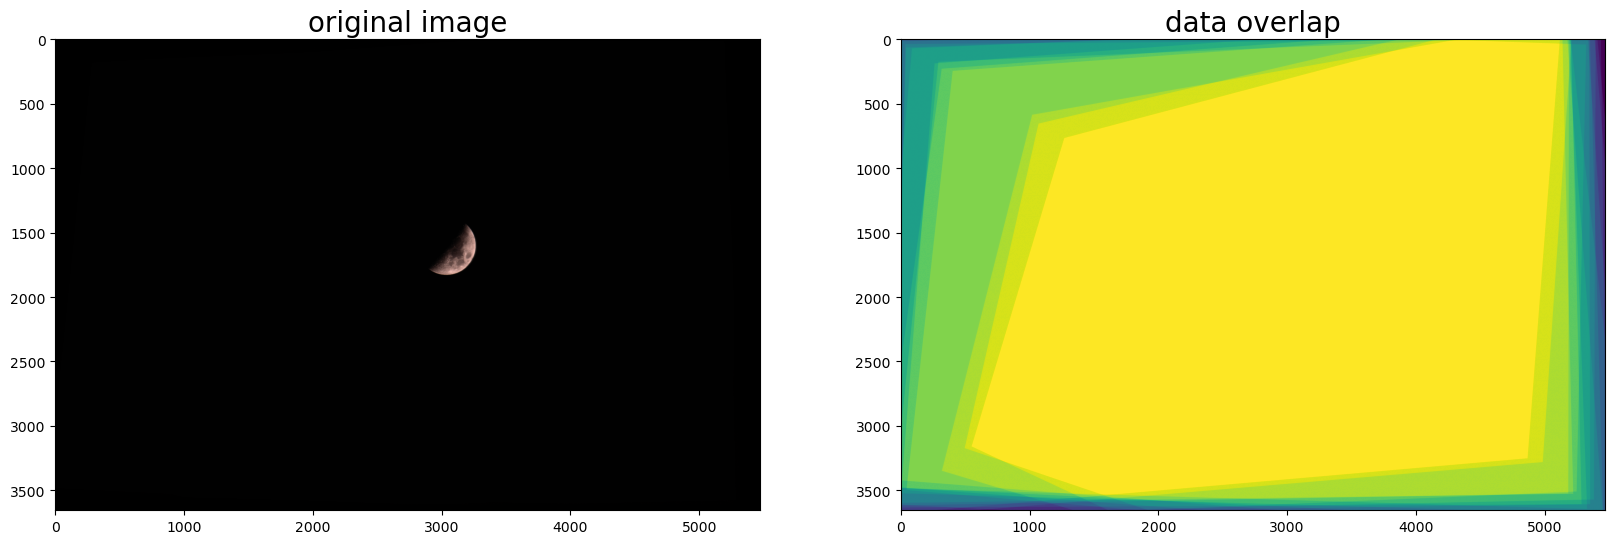

In [4]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('original image', fontsize=20)
plt.imshow(stacked_high,cmap='gray')
plt.axis('on')
ax1 = fig.add_subplot(1, 2, 2)
ax1.set_title('data overlap', fontsize=20)
plt.imshow(count_high)
plt.axis('on')
plt.savefig('cropping.png', 
            dpi=1000)

## Compare images cropped and stacked

(900, 1000)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


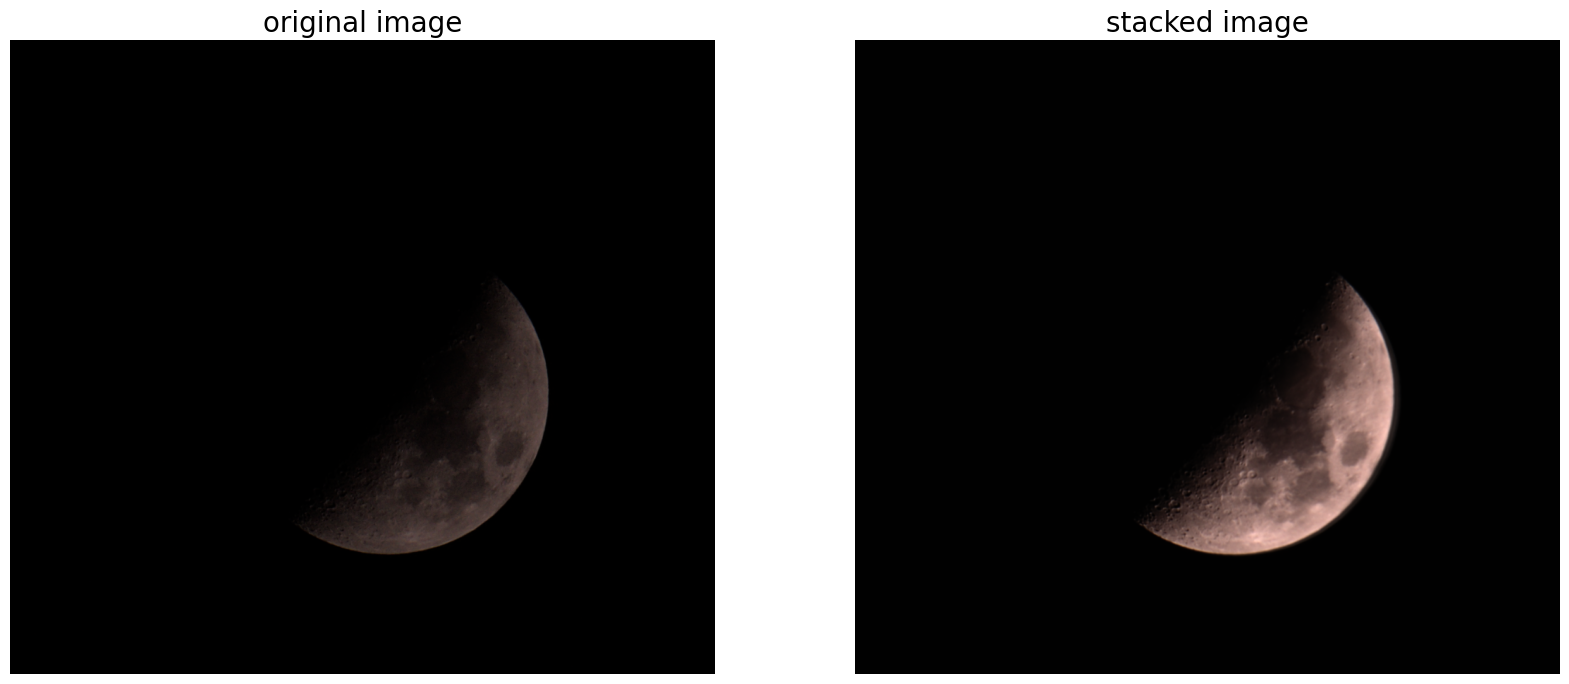

In [5]:
def crop(img):
    # return img[1100:2000,2500:3500] # for quarter moon
    return img[1100:2000,2500:3500] #
# double check that our cropped out region uses 100% of source images
print(crop(count_high).shape)
print(crop(count_high))
assert((crop(count_high)==1.0).all()) # checks to make sure all values are 1 and not a fraction

# cropped_original = crop(brighten(main,threshold=0.5))
# cropped_stacked = crop(brighten(stacked,threshold=0.5))
cropped_original = crop(main)
img= crop(stacked_high)

# # Save cropped figure
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# plt.imshow(cropped_original)
# plt.axis('off')
# plt.savefig('cropped_original.png',
#             dp1=1000)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('original image', fontsize=20)
plt.imshow(cropped_original, cmap='gray')
plt.axis('off')

ax1 = fig.add_subplot(1, 2, 2)
ax1.set_title('stacked image', fontsize=20)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.savefig('original_compare.png', 
            dpi=600)


## Comparison of stacking from high, mid and low

It is clear that in this case the more features produced a better image. This is likely because the moon does not have many features to pick from that can be aligned, so in this case, the more the better. There are still artifacts produced. These artifacts are seen in the blurring and "smearing" around the edges of the image.

Text(0.5, 1.0, 'Low feature')

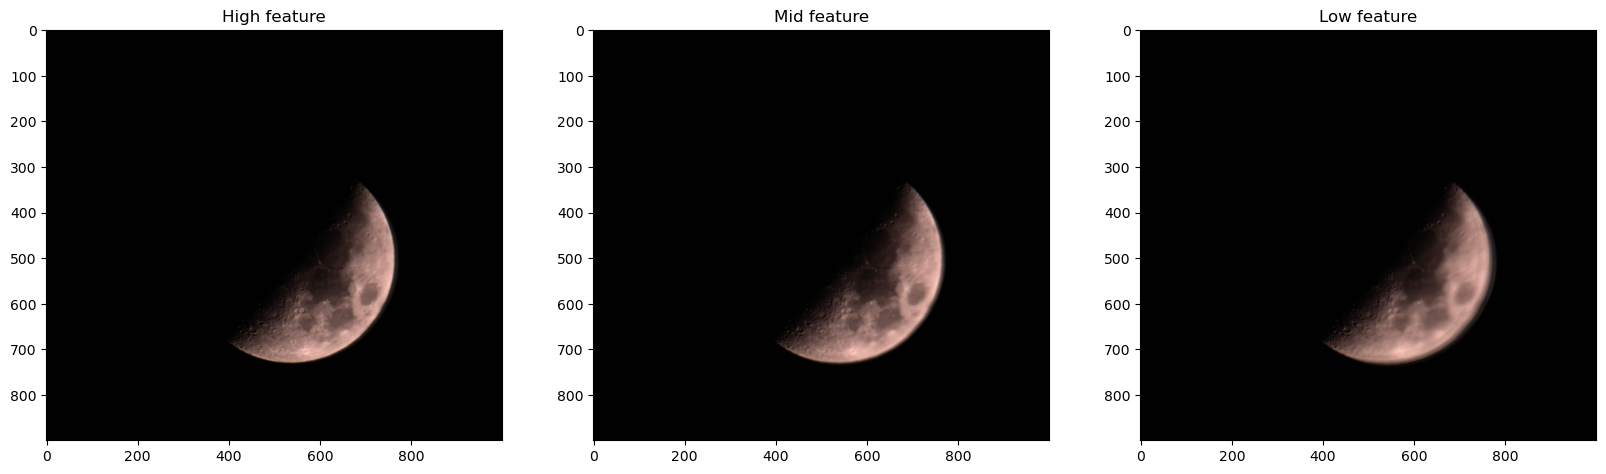

In [6]:
# Plot comparisons
fig = plt.figure(figsize=(20,20))
fig.add_subplot(1,3,1)
plt.imshow(crop(stacked_high))
plt.title('High feature')
fig.add_subplot(1,3,2)
plt.imshow(crop(stacked_mid))
plt.title('Mid feature')
fig.add_subplot(1,3,3)
plt.imshow(crop(stacked_low))
plt.title('Low feature')
# plt.savefig('stacked_compare.png', 
#             dpi=600)

## Check noise

Though I have not yet found a good way to quantify the noise mathematically, there is a clear decrease in noise that can be seen from observation.

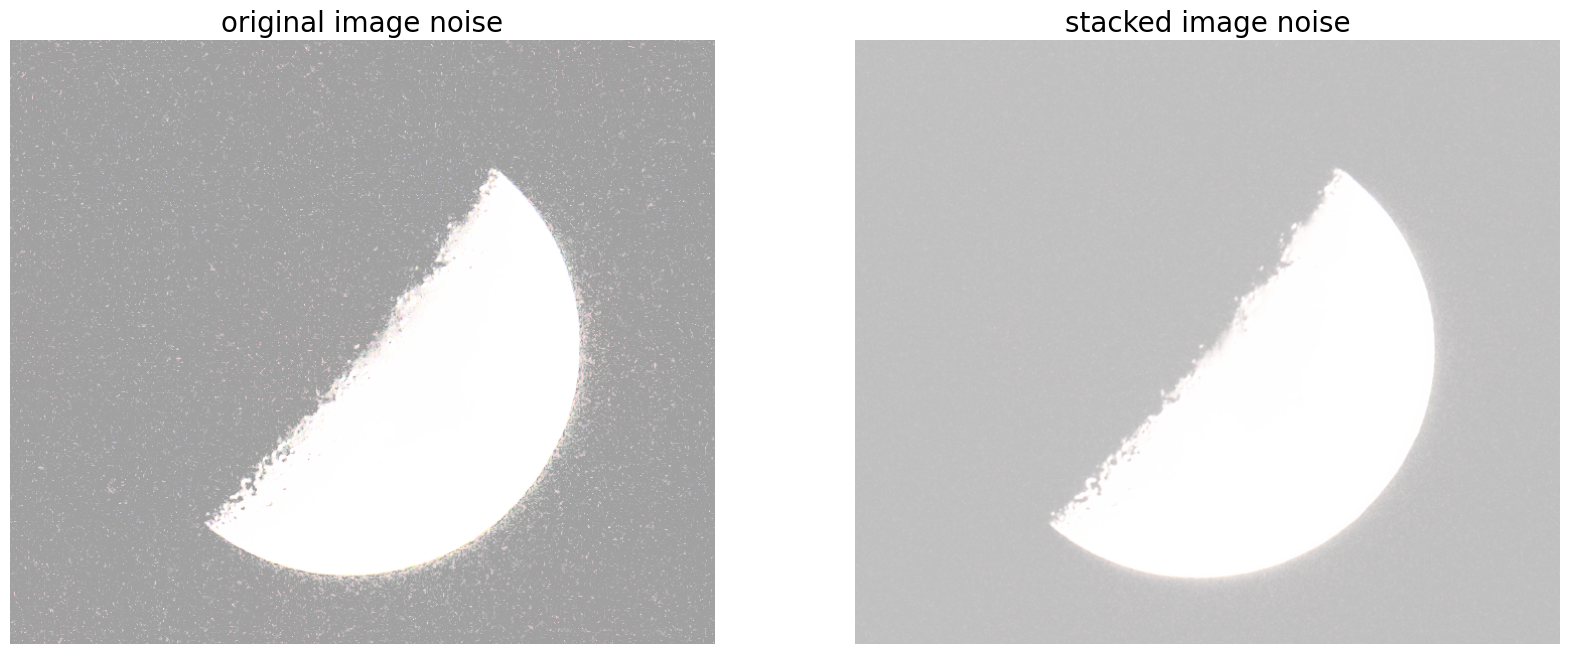

In [7]:
def crop(img):
    return img[1300:1900,2700:3400]
# double check that our cropped out region uses 100% of source images
assert((crop(count_high)==1.0).all()) 

cropped_original = crop(brighten(main,threshold=0.5))
cropped_stacked = crop(brighten(stacked_high,threshold=0.5))

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('original image noise', fontsize=20)
plt.imshow(cropped_original, cmap='gray')
plt.axis('off')
ax1 = fig.add_subplot(1, 2, 2)
ax1.set_title('stacked image noise', fontsize=20)
plt.imshow(cropped_stacked, cmap='gray')
plt.axis('off')
plt.savefig('noise_check.png', 
            dpi=1000)

I cannot seem to do anything to quantify the noise. Instead I am going to take the stacked image and try and run different filters and see the results.
https://towardsdatascience.com/massive-tutorial-on-image-processing-and-preparation-for-deep-learning-in-python-1-e534ee42f122

# Filters

2d convolusional filter

https://learnopencv.com/image-filtering-using-convolution-in-opencv/
https://blog.demofox.org/2022/02/26/image-sharpening-convolution-kernels/

The 2d convolution uses a kernel sharpening filter where convolution is defined as:

$g(x,y = \omega * f(x,y) = \sum_{dx=-\alpha}^{\alpha} \omega(dx,dy)f(x-dx,y-dy)$

Where $g(x,y)$ is the filtered image and $f(x,y)$ is the original image kernel. The sharpening kernel used is defined as:

$\omega =  \begin{bmatrix} 0 & -1 & 0\\ -1 & 5 & -1\\ 0 & -1 & 0 \end{bmatrix} $

The sharpening filter kernel acts as a derivative operator that sharpens the edges in an image.
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


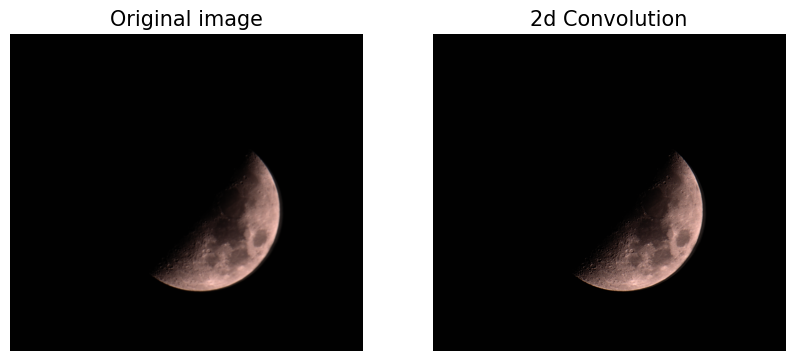

In [8]:
from skimage.color import rgb2gray
import skimage.filters as filt
k,

fig,axs = plt.subplots(nrows=1, ncols=2,figsize=(10,10))

# Sharpen with convolution
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
image_sharp = cv2.filter2D(src=img,
                           ddepth=-10,
                           kernel=kernel)
axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title('Original image',fontsize=15)
axs[1].imshow(image_sharp)
axs[1].axis('off')
axs[1].set_title('2d Convolution',fontsize=15)
plt.savefig('convolution_compare.png',
            dpi=1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 999.5, 899.5, -0.5)

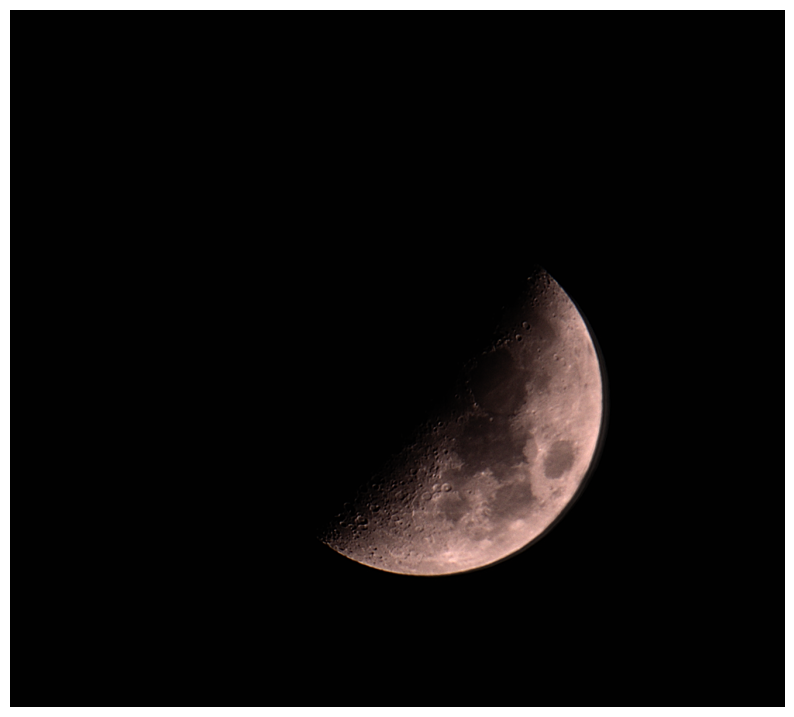

In [9]:
fig,axs = plt.subplots(nrows=1, ncols=1,figsize=(10,10))
axs.imshow(image_sharp)
axs.axis('off')
# axs.set_title('2d Convolution',fontsize=15)
# plt.savefig('convolution.png',
#             dpi=1000)